# Homework 5

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# Section 1: Harvard Case

*This section will not be graded, but it will be discussed in class.*

**Smart Beta Exchange-Traded-Funds and Factor Investing**.

* The case is a good introduction to important pricing factors.
* It also gives useful introduction and context to ETFs, passive vs active investing, and so-called “smart beta” funds.

1. Describe how each of the factors (other than MKT) is measured.1That is, each factor is a portfolio of stocks–which stocks are included in the factor portfolio?

2. Is the factor portfolio...
* long-only
* long-short
* value-weighted
* equally-weighted

4. What steps are taken in the factor construction to try to reduce the correlation between the factors?
5. What is the point of figures 1-6?
6. How is a “smart beta” ETF different from a traditional ETF?
7. Is it possible for all investors to have exposure to the “value” factor?
8. How does factor investing differ from traditional diversification?


If you need more info in how these factor portfolios are created, see Ken French’s website, and the follow- details: 

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_mom_factor.html

***

# 2. The Factors

Use the data found in `factor_pricing_data.xlsx`.

* FACTORS: Monthly excess return data for the overall equity market, $\tilde{r}^{\text{MKT}}$.
* The column header to the market factor is `MKT` rather than `MKT-RF`, but it is indeed already in excess return form.
* The sheet also contains data on five additional factors.
* All factor data is already provided as excess returns

1. Analyze the factors, similar to how you analyzed the three Fama-French factors in Homework 4.
You now have three additional factors, so let’s compare there univariate statistics. • mean
• volatility
• Sharpe

2. Based on the factor statistics above, answer the following.
(a) Does each factor have a positive risk premium (positive expected excess return)? (b) How have the factors performed since the time of the case, (2015-present)?

3. Report the correlation matrix across the six factors.
* Does the construction method succeed in keeping correlations small?
* Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

4. Report the tangency weights for a portfolio of these 6 factors.
* Which factors seem most important? And Least?
* Are the factors with low mean returns still useful?
* Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

What do you conclude about the importance or unimportance of these styles?

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

factors = pd.read_excel('../data/factor_pricing_data.xlsx', sheet_name='factors (excess returns)').set_index('Date')
portfolios = pd.read_excel('../data/factor_pricing_data.xlsx', sheet_name='portfolios (excess returns)').set_index('Date')


Helper functions:

In [116]:
def calc_performance_metrics(data, adj=12, var=0.05):
    """
    Aggregating function for calculating performance metrics. Returns both
    risk and performance metrics.

    Args:
        data (pd.DataFrame): DataFrame of asset returns.
        adj (int, optional): Annualization. Defaults to 12.
        var (float, optional): VaR level. Defaults to 0.05.

    Returns:
        DataFrame: DataFrame of performance metrics.
    """
    summary = {
        **calc_return_metrics(data=data, adj=adj),
        **calc_risk_metrics(data=data, var=var),
    }
    summary["Calmar Ratio"] = summary["Annualized Return"] / abs(
        summary["Max Drawdown"]
    )
    return pd.DataFrame(summary, index=data.columns)

In [117]:
def calc_return_metrics(data, as_df=False, adj=12):
    """
    Calculate return metrics for a DataFrame of assets.

    Args:
        data (pd.DataFrame): DataFrame of asset returns.
        as_df (bool, optional): Return a DF or a dict. Defaults to False (return a dict).
        adj (int, optional): Annualization. Defaults to 12.

    Returns:
        Union[dict, DataFrame]: Dict or DataFrame of return metrics.
    """
    summary = dict()
    summary["Annualized Return"] = data.mean() * adj
    summary["Annualized Volatility"] = data.std() * np.sqrt(adj)
    summary["Annualized Sharpe Ratio"] = (
        summary["Annualized Return"] / summary["Annualized Volatility"]
    )
    summary["Annualized Sortino Ratio"] = summary["Annualized Return"] / (
        data[data < 0].std() * np.sqrt(adj)
    )
    return pd.DataFrame(summary, index=data.columns) if as_df else summary

In [118]:
def calc_risk_metrics(data, as_df=False, var=0.05):
    """
    Calculate risk metrics for a DataFrame of assets.

    Args:
        data (pd.DataFrame): DataFrame of asset returns.
        as_df (bool, optional): Return a DF or a dict. Defaults to False.
        adj (int, optional): Annualizatin. Defaults to 12.
        var (float, optional): VaR level. Defaults to 0.05.

    Returns:
        Union[dict, DataFrame]: Dict or DataFrame of risk metrics.
    """
    summary = dict()
    summary["Skewness"] = data.skew()
    summary["Excess Kurtosis"] = data.kurtosis()
    summary[f"VaR ({var})"] = data.quantile(var, axis=0)
    summary[f"CVaR ({var})"] = data[data <= data.quantile(var, axis=0)].mean()
    summary["Min"] = data.min()
    summary["Max"] = data.max()

    wealth_index = 1000 * (1 + data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary["Max Drawdown"] = drawdowns.min()

    summary["Bottom"] = drawdowns.idxmin()
    summary["Peak"] = previous_peaks.idxmax()

    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][: drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin() :]]).T
        recovery_date.append(
            recovery_wealth[recovery_wealth[col] >= prev_max].index.min()
        )
    summary["Recovery"] = ["-" if pd.isnull(i) else i for i in recovery_date]

    summary["Duration (days)"] = [
        (i - j).days if i != "-" else "-"
        for i, j in zip(summary["Recovery"], summary["Bottom"])
    ]

    return pd.DataFrame(summary, index=data.columns) if as_df else summary

1.

In [119]:
numeric_factors = factors.select_dtypes(include=[np.number])
summary = calc_performance_metrics(numeric_factors).iloc[:, :3]
summary

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
MKT,0.086277,0.156904,0.549872
SMB,0.008319,0.101873,0.081665
HML,0.025809,0.109999,0.234629
RMW,0.047096,0.083213,0.565962
CMA,0.029537,0.073084,0.404148
UMD,0.062709,0.154564,0.405714


2.

Yes each factor has positive risk premia

In [133]:
OOS = calc_performance_metrics(factors.loc[:'2014']).iloc[:, :3]
IS = calc_performance_metrics(factors.loc['2015':]).iloc[:, :3]

IS



,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
MKT,0.116586,0.160285,0.727369
SMB,-0.019500,0.104524,-0.186559
HML,-0.017855,0.132709,-0.134544
RMW,0.050886,0.073338,0.693862
CMA,-0.008410,0.083989,-0.100137
UMD,0.021083,0.140812,0.149723


In [134]:
OOS

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
MKT,0.077906,0.156064,0.499189
SMB,0.016003,0.101142,0.158221
HML,0.037869,0.102760,0.368514
RMW,0.046049,0.085819,0.536579
CMA,0.040017,0.069580,0.575120
UMD,0.074206,0.158149,0.469215


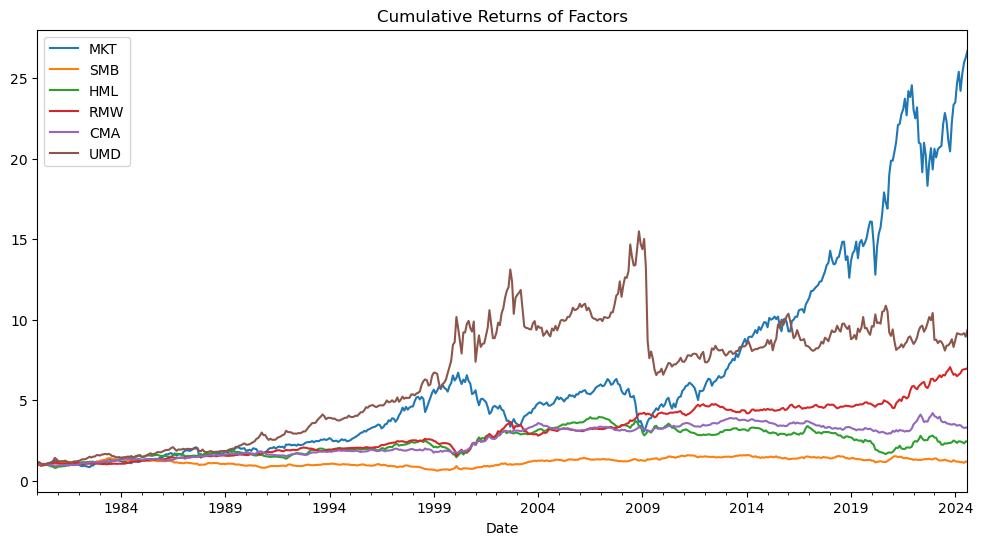

In [121]:
cumulative_returns = (1 + numeric_factors).cumprod()
cumulative_returns.plot(figsize=(12, 6), title="Cumulative Returns of Factors")
plt.show()


Market has performed the best out of each factor since 2015, previously, UMD was the best for a majority of the dataset until the 2010's

3.

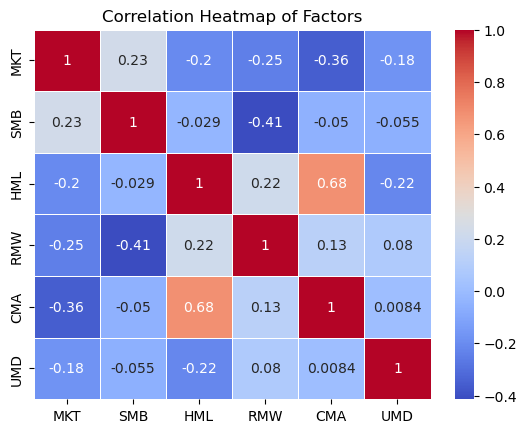

In [122]:

sns.heatmap(numeric_factors.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Factors')
plt.show()


Yes, the construction method keeps the correlations small, besides CMA HML (0.68) and SMB RMW (-0.41).

I would not say it is redundant, although it may have some of the higher correlations, it is still useful for what is not picked up by RMW and CMA.

4.

Helper function:

In [123]:
def tangency_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    return pd.DataFrame(weights, index=returns.columns,columns=['tangency weights'])

In [124]:
w_t = tangency_weights(factors)
w_t

,tangency weights
MKT,0.209760
SMB,0.077337
HML,-0.042142
RMW,0.313263
CMA,0.338982
UMD,0.102798


The most important facotrs are RMA, RMW, MKT as shown by their weights. The least important are HML, SMB and UMD.

The factors with the highest mean returns have been MKT and UMD which are the two most median factors by weight. So yes, even the lower weight factors are useful.

In [125]:
factors_a = factors[['MKT', 'SMB', 'HML', 'UMD']]
w_t_fa = tangency_weights(factors_a)
w_t_fa

,tangency weights
MKT,0.365529
SMB,-0.032422
HML,0.356199
UMD,0.310694


Now MKT, HML, and UMD have the highest weights (near even with eachother) and SMB has dropped below 0.

Although taking the tangency weights of all the factors may provide more information, the usefulness of the 4 factor tangency weights is much greater.

***

# 3. Testing Modern LPMs

Consider the following factor models:
* CAPM: MKT
* Fama-French 3F: MKT, SMB, HML
* Fama-French 5F: MKT, SMB, HML, RMW, CMA
* AQR: MKT, HML, RMW, UMD

We are not saying this is “the” AQR model, but it is a good illustration of their most publicized factors: value, momentum, and more recently, profitability.

For instance, for the AQR model is...

![](../refs/LFP-4-factors.png)

We will test these models with the time-series regressions. Namely, for each asset i, estimate the following regression to test the AQR model:

![](../refs/LFD-4-factors.png)

Data
* PORTFOLIOS: Monthly excess return data on 49 equity portfolios sorted by their industry. Denote these as $\tilde{r}^i$ , for $n = 1, . . . , 49.$

* You do NOT need the risk-free rate data. It is provided only for completeness. The other two tabs are already in terms of excess returns.

1. Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)
* For each regression, report the estimated α and r-squared.
* Calculate the mean-absolute-error of the estimated alphas.
* If the pricing model worked, should these alpha estimates be large or small? Why?
* Based on your MAE stat, does this seem to support the pricing model or not?

2. Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model.
   * Report the MAE statistic for each of these models and compare it with the AQR Model MAE.
   * Which model fits best?
   
3. Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?

4. This does not matter for pricing, but report the average (across $n$ estimations) of the time-series regression r-squared statistics.
   * Do this for each of the three models you tested.
   * Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?

5. We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.
* Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?4
* Report the MAE of the cross-sectional regression residuals for each of the four models. How do they compare to the MAE of the time-series alphas?

1.

In [126]:
import statsmodels.api as sm

capm = factors[['MKT']]
ff3 = factors[['MKT', 'SMB', 'HML']]
ff5 = factors[['MKT', 'SMB', 'HML', 'RMW', 'CMA']]
aqr = factors[['MKT', 'SMB', 'HML', 'UMD']]

def time_series_regression(data, factors):
    results = pd.DataFrame(index=data.columns, columns=['alpha', 'r_squared'])
    for col in data.columns:
        y = data[col]
        x = factors
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        results.loc[col, 'alpha'] = model.params['const']
        results.loc[col, 'r_squared'] = model.rsquared
    return results

aqr_results = time_series_regression(portfolios, aqr)

aqr_results


,alpha,r_squared
Agric,0.000714,0.360477
Food,0.002489,0.420629
Soda,0.003376,0.282197
Beer,0.003703,0.371999
Smoke,0.005504,0.236212
Toys,-0.002085,0.535811
Fun,0.002252,0.625506
Books,-0.001588,0.691148
Hshld,0.001207,0.515003
Clths,0.000793,0.586925


The following includes part of 2.

In [127]:
def calc_mae(data, factors):
    results = time_series_regression(data, factors)
    return results['alpha'].abs().mean()

mae_capm = calc_mae(portfolios, capm)
mae_aqr = calc_mae(portfolios, aqr)
mae_ff3 = calc_mae(portfolios, ff3)
mae_ff5 = calc_mae(portfolios, ff5)

mae = pd.DataFrame({
    'CAPM': mae_capm,
    'AQR': mae_aqr,
    'FF3': mae_ff3,
    'FF5': mae_ff5
}, index=['MAE'])

mae.T

,MAE
CAPM,0.001700
AQR,0.001809
FF3,0.001999
FF5,0.002614


If the pricing model worked we would expect MAE near 0, this value explains the accuracy of the model.

No it does not support the pricing model, they all have around a 2% error which over time is a drastic difference.

2.

It is shown above that CAPM is the best model. The FF3 and FF5 models are both worse than AQR. Hence the CAPM fits best.

3.

The most important is MKT because of the actual mean returns. But because

In [129]:
CAPMM = time_series_regression(portfolios, capm)
CAPMM_R = CAPMM['r_squared'].mean()

AQRMM = time_series_regression(portfolios, aqr)
AQRMM_R = AQRMM['r_squared'].mean()

FF3MM = time_series_regression(portfolios, ff3)
FF3MM_R = FF3MM['r_squared'].mean()

FF5MM = time_series_regression(portfolios, ff5)
FF5MM_R = FF5MM['r_squared'].mean()

r_squared = pd.DataFrame({
    'CAPM': CAPMM_R,
    'AQR': AQRMM_R,
    'FF3': FF3MM_R,
    'FF5': FF5MM_R
}, index=['R Squared'])

r_squared.T

,R Squared
CAPM,0.526107
AQR,0.577029
FF3,0.571484
FF5,0.595951


***